## Imports

In [1]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import tensorflow as tf
import shutil
import os, sys
from time import time
import pandas as pd



from Jet_Observables import NSubJettiness, Thrust, Uniform, Disk, Ellipse, Point, NStructure
from src.Observables import CustomObservable
# # eKDS Stuff
# from src.Graph import Background, Circle, Disk
# from src.eKDS import Graph, eKDS, emd
from src.utils.plot_utils import load_data, plot, plot_event, make_gif, timer_func
from utils import load_dataset

/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Datasets

This part of the code can be modified, as long as the final datasets have the same format! Doesn't have to be physics-themed

In [2]:
# Parameters
R = 0.5
beta = 1.0
N = 250
epochs = 75
mass_lower = 145
mass_upper = 205
eta_cut = 1.3
plot_dir = "results"



signal, signal_masses = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta_cut)
background, background_masses = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta_cut)
events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]


fake_top, fake_top_z = np.array(( (-1.0,0.0), (0.0,0.0), (1.0,0.0),)), np.array((1/3, 1/3, 1/3))
fake_signal = ((fake_top, fake_top_z), )
fake_quark, fake_quark_z = np.array(((0.0,0.0),)), np.array((1.0, ))
fake_background = ((fake_quark, fake_quark_z),)
fake_events = [fake_signal, fake_background]

(25000, 200, 3)
171.30413009311044
158.9693130074576
161.6709548277763
217.78496066391168
157.1739932749623
145.224438230974
210.35511596145994
177.41657786466106
162.74283877110196
163.63866635517257
170.3576439203059
184.45016632605598
141.4605829588729
175.44704442677346
184.92676363567008
162.4442373605805
148.9623001817155
165.37205399302044
188.76134723766813
196.78699343734533
159.86244258701095
141.6034302870565
156.7598874524902
186.42487167181534
176.3970632284652
176.03360787616168
206.68555074523508
226.98550730611316
197.07720436144035
199.08915373514188
194.02682045703895
222.23402839990294
189.07924913438973
194.60076760887804
153.22383957002594
184.61172023317496
181.1678834389061
177.36232493923788
176.75793699476736
169.7813773435615
164.98595747505686
160.1663605195856
181.10157347849085
167.8657250667833
156.9408770372269
216.71362782196286
183.82859213843093
137.17973524294436
209.40836609362938
159.55058490438918
172.14346141202506
188.02718152560792
175.928192452

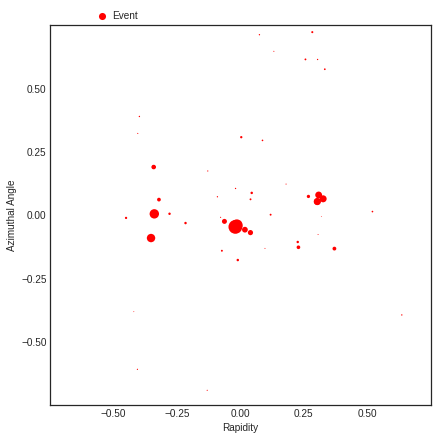

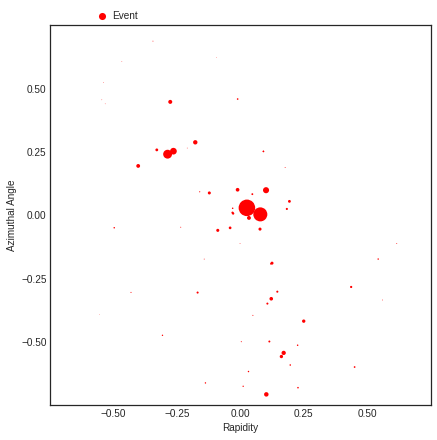

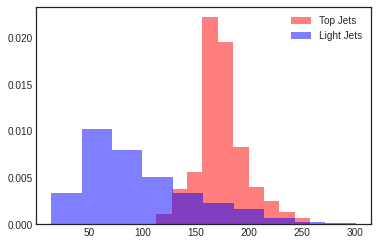

In [3]:
# Example plots
example_signal = signal[0]
plot_event(example_signal[0], example_signal[1], R, color = "red")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

plt.hist(signal_masses, color = "red", alpha = 0.5, label = "Top Jets", density = True)
plt.hist(background_masses, color = "blue", alpha = 0.5, label = "Light Jets", density = True)
plt.legend()



## Observables

In [4]:
# _1subjettinesss = NSubJettiness(
#                     initializer = "kt", N = 1, R = R, beta = beta)
# _2subjettinesss = NSubJettiness(
#                     initializer = "kt", N = 2, R = R, beta = beta)
# _3subjettinesss = NSubJettiness(
#                     initializer = "kt", N = 3, R = R, beta = beta)

_1subjettiness = NStructure(Point, N = 1, name = "1-Subjettiness", initializer = "kt", R = R, beta = beta)
_2subjettiness = NStructure(Point, N = 2, name = "2-Subjettiness", initializer = "kt", R = R, beta = beta)
_3subjettiness = NStructure(Point, N = 3, name = "3-Subjettiness", initializer = "kt", R = R, beta = beta)

# _thrust = Thrust(initializer = (0,0), R = R, beta = beta)

_1diskiness_plus_pileup = CustomObservable(
                            shapes = [Uniform((-R, -R), (R, R), z = 0, N = 75),
                                      Disk( (0.0,0.0), R/2, z = 1.0, N = 75) ], name = "1-Diskiness + Pileup", R = R, beta = beta)
_2diskiness_plus_pileup = CustomObservable(
                            shapes = [Uniform((-R, -R), (R, R), z = 0, N = 75),
                                      Disk( (-R/2,0.0), R/2, z = 0.5, N = 75),
                                      Disk( (R/2,0.0), R/2, z = 0.5, N = 75) ], name = "2-Diskiness + Pileup", R = R, beta = beta)
_3diskiness_plus_pileup = CustomObservable(
                            shapes = [Uniform((-R, -R), (R, R), z = 0, N = 75),
                                     Disk( (0.0,0.0), R/2, z = 0.333, N = 75),
                                     Disk( (-R/2,0.0), R/2, z= 0.333, N = 75),
                                     Disk( (R/2,0.0), R/2, z = 0.333, N = 75) ], name = "3-Diskiness + Pileup", R = R, beta = beta)

_isotropy = Uniform((-R, -R), (R, R), z = 1, trainable_z = False, R = R, beta = 1.0, N = 100)

_1ellipsiness = CustomObservable(
                            shapes = [
                                     Ellipse( (0.0,0.0), R/2, z = 0.333, N = 100),], ids = [1], name = "1-Ellipsiness", R = R, beta = beta)  

_1ellipsiness_plus_pileup = CustomObservable(
                            shapes = [Uniform((-R, -R), (R, R), z = 0, N = 100),
                                     Ellipse( (0.0,0.0), R/2, z = 0.333, N = 100),], name = "1-Ellipsiness + Pileup", R = R, beta = beta)      


_3ellipsiness = CustomObservable(
                            shapes = [
                                     Ellipse( (0.0,0.0), R/2, z = 0.333, N = 50),
                                     Ellipse( (-R,0.0), R/2, z= 0.333, N = 50),
                                     Ellipse( (R,0.0), R/2, z = 0.333, N = 50) ], ids = [1, 2, 3], name = "3-Ellipsiness", R = R, beta = beta)  

_3ellipsiness_plus_pileup = CustomObservable(
                            shapes = [Uniform((-R, -R), (R, R), z = 0, N = 75),
                                     Ellipse( (0.0,0.0), R/2, z = 0.333, N = 75),
                                     Ellipse( (-R,0.0), R/2, z= 0.333, N = 75),
                                     Ellipse( (R,0.0), R/2, z = 0.333, N = 75) ], name = "3-Ellipsiness + Pileup", R = R, beta = beta)                                     

observables = [
              _1subjettiness, _2subjettiness, _3subjettiness,
               #    _thrust, 
               # _3diskiness_plus_pileup,
            #    _isotropy,
               # _3ellipsiness,
               # _1ellipsiness_plus_pileup
               ]

training_config_dict = {"epochs" : 500,
                        "optimizer" : tf.keras.optimizers.Adam(lr = 0.0025),
                        "verbose" : False,
                        "early_stop" : 25,
                        "resample" : True,
                        "z_schedule": 0.1}

## Run 

In [5]:
# # TEST ON IDEAL EVENTS

# # Calculate the EMDs for each observable, for each event
# for (i, event_type) in enumerate(events):
#     for (j, obs) in enumerate(observables[1:2]):
#         for (k, event) in enumerate(events[i][0:2]):

#             t1 = time()
#             params = obs.calculate(event, training_config_dict, gif_filename = "temp/test_%s_%d_%s.gif" % (event_labels[i], k, obs.name), plot_filename="temp/%s/test_%d_%s.png" % (event_labels[i], k, obs.name))
#             print(params)
#             t2 = time()
#             print("Event %d" %k, "Obs: %s" % obs.name, "Class: %s" % event_labels[i], "Value: %.3f" % params["EMD"], "Finished in %.3fs" % (t2 - t1))   

In [6]:

emds = np.zeros(shape = (len(events),len(observables), N))
param_dicts = [[],[], []]

# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
    for (j, obs) in enumerate(observables):
        for (k, event) in enumerate(events[i]):

            t1 = time()
            params = obs.calculate(event, training_config_dict, plot_filename="temp/%s/test_%d_%s.png" % (event_labels[i], k, obs.name))
            emds[i,j,k] = params["EMD"]
            param_dicts[j].append(params)
            t2 = time()

            print("Event %d" %k, "Obs: %s" % obs.name, "Class: %s" % event_labels[i], "Value: %.3f" % params["EMD"], "Finished in %.3fs" % (t2 - t1))

Event 0 Obs: 1-Subjettiness Class: signal Value: 0.476 Finished in 7.174s
Event 1 Obs: 1-Subjettiness Class: signal Value: 0.569 Finished in 0.470s
Event 2 Obs: 1-Subjettiness Class: signal Value: 0.422 Finished in 0.603s
Event 3 Obs: 1-Subjettiness Class: signal Value: 0.461 Finished in 0.555s
Event 4 Obs: 1-Subjettiness Class: signal Value: 0.439 Finished in 0.507s
Event 5 Obs: 1-Subjettiness Class: signal Value: 0.675 Finished in 0.532s
Event 6 Obs: 1-Subjettiness Class: signal Value: 0.397 Finished in 0.597s
Event 7 Obs: 1-Subjettiness Class: signal Value: 0.596 Finished in 0.734s
Event 8 Obs: 1-Subjettiness Class: signal Value: 0.620 Finished in 0.540s
Event 9 Obs: 1-Subjettiness Class: signal Value: 0.604 Finished in 0.533s
Event 10 Obs: 1-Subjettiness Class: signal Value: 0.460 Finished in 0.538s
Event 11 Obs: 1-Subjettiness Class: signal Value: 0.560 Finished in 0.491s
Event 12 Obs: 1-Subjettiness Class: signal Value: 0.404 Finished in 0.609s
Event 13 Obs: 1-Subjettiness Class:

## Plots

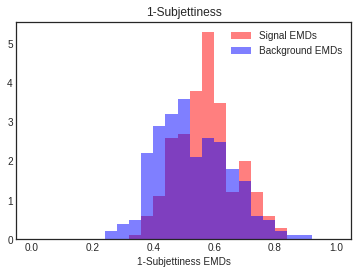

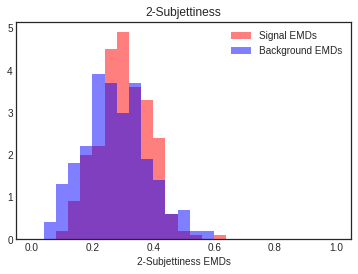

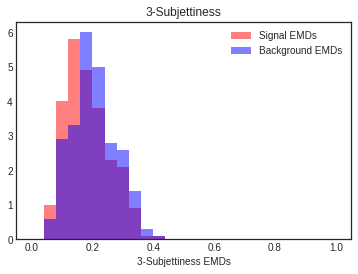

In [7]:
np.save("emds.npy", emds, )

df = pd.DataFrame(param_dicts[0])
df.to_csv("dataframe_3ellipsiness.csv")

# df = pd.DataFrame(param_dicts[1])
# df.to_csv("dataframe_1ellipsiness_plus_pileup.csv")

# df = pd.read_csv("dataframe_1ellipsiness.csv")
# print(df.head(10))


for (j, obs) in enumerate(observables):
    plt.hist(emds[0,j,:], bins = 25, range=(0.0, 1.0), density = True, color = "red", label = "Signal EMDs", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds[1,j,:], bins = 25, range=(0.0, 1.0), density = True, color = "blue", label = "Background EMDs", histtype="stepfilled", alpha = 0.5)
    plt.title(obs.name)
    plt.xlabel(r"%s EMDs" % obs.name)
    plt.legend()
    plt.show()
    

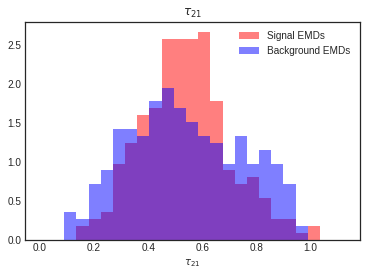

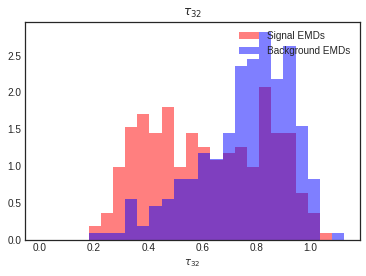

IndexError: index 3 is out of bounds for axis 1 with size 3

In [11]:
for (j, obs) in enumerate(observables):
    plt.hist(emds[0,j+1,:] / emds[0,j,:], bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Signal EMDs", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds[1,j+1,:] / emds[1,j,:], bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background EMDs", histtype="stepfilled", alpha = 0.5)
    plt.title(r"$\tau_{%d %d}$" % (j+2, j+1))
    plt.xlabel(r"$\tau_{%d %d}$" % (j+2, j+1))
    plt.legend()
    plt.show()
    

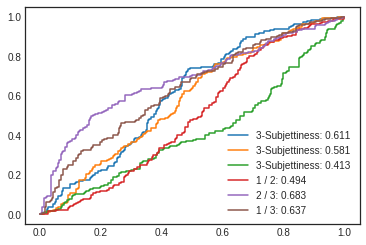

In [12]:
# AUC 
from sklearn import metrics

y = np.array([1]*N + [0]*N)
for j in range(len(observables)):
    pred = np.concatenate( (emds[0,j,:], emds[1,j,:]))
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    plt.plot(fpr, tpr, label = "%s: %.3f" %(obs.name,metrics.auc(fpr, tpr) ))


def sigmoid(z):
    return 1/(1+np.exp(-z))

combos = ((0,1), (1,2), (0,2))
for combo in combos:
    pred = sigmoid(np.concatenate( (emds[0,combo[0],:], emds[1,combo[0],:])) / np.concatenate( (emds[0,combo[1],:], emds[1,combo[1],:])))
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    plt.plot(fpr, tpr, label = "%d / %d: %.3f" % (combo[0]+1, combo[1]+1,metrics.auc(fpr, tpr) ))
# plt.plot(fpr, tpr, label = "%s: %.3f" %("1 / 3",metrics.auc(fpr, tpr) ))

plt.legend()
# plt.plot(fpr, tpr, label = "%s: %.3f" %("1 / 3",metrics.auc(fpr, tpr) ))







(250, 3)
(250, 3)


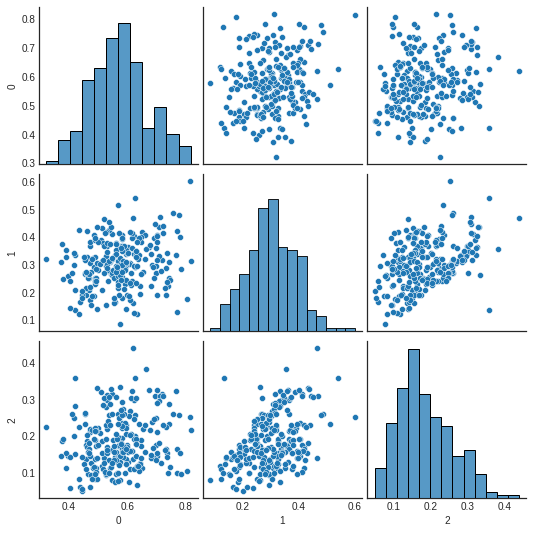

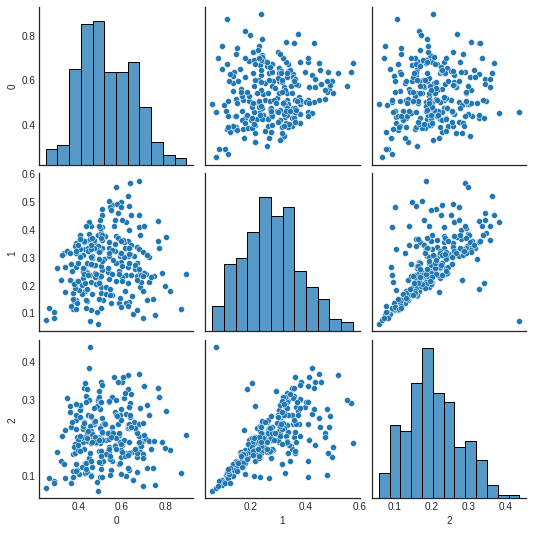

In [10]:
# Fancy plots
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.transpose(emds[0]), )
print(df.shape)
sns.pairplot(df)

df = pd.DataFrame(np.transpose(emds[1]), )
print(df.shape)
sns.pairplot(df)


In [ ]:
import pandas as pd



df = pd.read_csv("dataframe_1ellipsiness_plus_pileup.csv")
eccentricities = df["eccentricity_1"]

signal_df = pd.read_csv("dataframe_3ellipsiness_signal.csv")
background_df = pd.read_csv("dataframe_3ellipsiness_background.csv")




observables = ["EMD"]
signal_eccentricities = np.amax(signal_df[observables].to_numpy(), axis = 1)
background_eccentricities = np.amax(background_df[observables].to_numpy(), axis = 1)
print(signal_eccentricities.shape, background_eccentricities)

plt.hist(signal_eccentricities, range = (0,1), bins = 15, density= True, alpha = 0.5, color = "red", label = "Top Jet")
plt.hist(background_eccentricities, range = (0,1), bins = 15, density= True, alpha = 0.5, color = "blue", label = "Light Jet")
